In [ ]:
import tensorflow as tf
import numpy as np

# Load the MNIST dataset
mnist = tf.keras.datasets.mnist

# Split the dataset into training and testing sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

height, width =  28, 28

# Print the shape of the training and testing data
print("Shape of training data: ", x_train.shape)
print("Shape of training labels: ", y_train.shape)
print("Shape of testing data: ", x_test.shape)
print("Shape of testing labels: ", y_test.shape)

11490434/11490434 [==============================] - 0s 0us/step
Shape of training data:  (60000, 28, 28)
Shape of training labels:  (60000,)
Shape of testing data:  (10000, 28, 28)
Shape of testing labels:  (10000,)


In [ ]:
from PIL import Image
import os
import numpy as np
from glob import glob
from matplotlib import pyplot as plt

import zlib
import gzip
import lzma
from io import BytesIO
!pip install ffmpeg-python
import ffmpeg

from sklearn.neighbors import KNeighborsClassifier
from IPython.display import clear_output
clear_output()

In [ ]:
def size_compr_im(img, comp):
  
  buffer = BytesIO()
  img.convert('RGB').save(buffer, comp)

  return(buffer.getbuffer().nbytes)

comp_map = {'gzip': gzip, 'lzma': lzma, 'zlib': zlib, 'jpeg': 'JPEG', 'gif': 'GIF', 'png': 'PNG'}

In [ ]:
def concat_im(im1, im2, axis=0):
    """
    Concatening images horizontally (axis=0) or vertically (axis=1)
    """

    if axis==0:
      dst = Image.new('RGB', (im1.width + im2.width, im1.height))
      dst.paste(im1, (0, 0))
      dst.paste(im2, (im1.width, 0))

    else:
      dst = Image.new('RGB', (im1.width, im1.height + im2.height))
      dst.paste(im1, (0, 0))
      dst.paste(im2, (0, im1.height))
    return dst


def ncd(arr_im1, arr_im2, comp='jpeg'):

  im1 = Image.fromarray(arr_im1)
  im2 = Image.fromarray(arr_im2)

  im12 = concat_im(im1, im2)

  compressor = comp_map[comp]

  if comp in ['lzma', 'gzip', 'zlib']:
    c1 = len(compressor.compress(im1.tobytes()))
    c2 = len(compressor.compress(im2.tobytes()))
    c12 = len(compressor.compress(im12.tobytes()))
  
  else:
    c1 = size_compr_im(im1, compressor)
    c2 = size_compr_im(im2, compressor)
    c12 = size_compr_im(im12, compressor)

  ncd = (c12 - min(c1, c2))/max(c1, c2)

  return ncd

In [ ]:
def concat_inter(arr_im1, arr_im2, axis=0):
  """
    Concatening images line by line (axis=0) or column by column (axis=1)
  """

  if axis == 0:
    c = arr_im1[0]
    
    for i in range(arr_im1.shape[0]):
      c = np.vstack((c, arr_im1[i]))
      c = np.vstack((c, arr_im2[i]))
    
    im = Image.fromarray(c[1:])
  
  else:
    c = np.column_stack((arr_im1, arr_im2)).reshape(-1,2,28).transpose(0,2,1).reshape(28,-1)
    im = Image.fromarray(c)

  return(im)



def ncd2(arr_im1, arr_im2, comp='gif'):

  arr_im1 = arr_im1.reshape(height, width)
  arr_im2 = arr_im2.reshape(height, width)

  im1 = Image.fromarray(arr_im1)
  im2 = Image.fromarray(arr_im2)

  im12 = concat_inter(arr_im1, arr_im2, axis=1)

  compressor = comp_map[comp]

  if comp in ['lzma', 'gzip', 'zlib']:
    c1 = len(compressor.compress(im1.tobytes()))
    c2 = len(compressor.compress(im2.tobytes()))
    c12 = len(compressor.compress(im12.tobytes()))
  
  else:
    c1 = size_compr_im(im1, compressor)
    c2 = size_compr_im(im2, compressor)
    c12 = size_compr_im(im12, compressor)

  ncd = (c12 - min(c1, c2))/max(c1, c2)

  return ncd

In [ ]:
# Checking the normality of the NCD
n = 0
for i in range(len(x_test)):
  n += ncd2(x_test[i], x_test[i])
print(n/len(x_test))

In [ ]:
# verticalement
clf = KNeighborsClassifier(n_neighbors=1, metric=ncd)
clf.fit(x_train[:10000].reshape(10000, 28*28), y_train[:10000])

KNeighborsClassifier(metric=<function ncd at 0x7fd1e503bc10>, n_neighbors=1)

In [ ]:
test_size = 100
y_pred = []
for i, x in enumerate(x_test[:test_size].reshape(test_size, 28*28)):
  if (i%10==0):clear_output()
  print(f"{i+1}/{test_size}")

  pred = clf.predict([x])

  print(f"(Real, Pred): {y_test[i]}, {pred[0]}" )

  y_pred.append(pred[0])

  print(f"Current accuracy: {np.mean(((y_test[:i+1]==y_pred)*100.0))}%")
  print()

y_pred = np.array(y_pred)

91/100
(Real, Pred): 3, 3
Current accuracy: 92.3076923076923%

92/100
(Real, Pred): 6, 6
Current accuracy: 92.3913043478261%

93/100
(Real, Pred): 9, 4
Current accuracy: 91.39784946236558%

94/100
(Real, Pred): 3, 3
Current accuracy: 91.48936170212765%

95/100
(Real, Pred): 1, 1
Current accuracy: 91.57894736842105%

96/100
(Real, Pred): 4, 4
Current accuracy: 91.66666666666667%

97/100
(Real, Pred): 1, 1
Current accuracy: 91.75257731958763%

98/100
(Real, Pred): 7, 7
Current accuracy: 91.83673469387755%

99/100
(Real, Pred): 6, 6
Current accuracy: 91.91919191919192%

100/100
(Real, Pred): 9, 9
Current accuracy: 92.0%



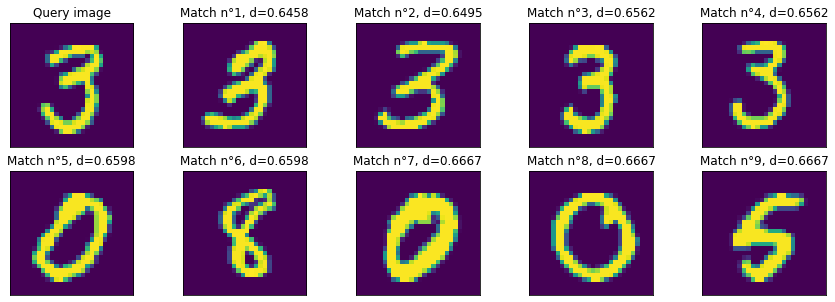

In [ ]:
fig, axs = plt.subplots(2,5, figsize=(15, 5))
axs = axs.ravel()
    
img = Image.fromarray(x_train[10011])
axs[0].imshow(img)
axs[0].title.set_text('Query image')
axs[0].set_xticks([]) 
axs[0].set_yticks([])
i=0
for k in l[0]:
  img = Image.fromarray(x_train[k])
  axs[i+1].imshow(img)
  axs[i+1].title.set_text('Match n°%d, d=%.4f'%(i+1, d[i]))
  axs[i+1].set_xticks([])
  axs[i+1].set_yticks([])
  i+=1

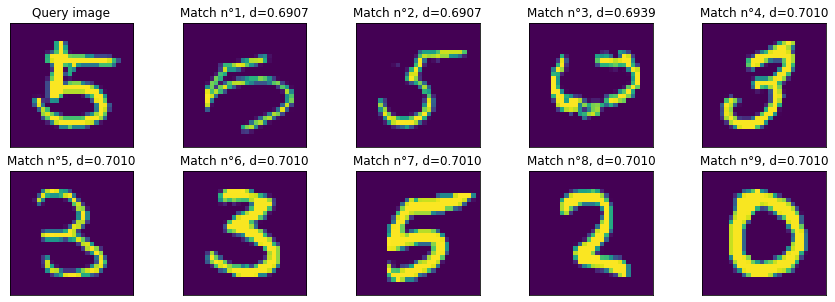

In [ ]:
fig, axs = plt.subplots(2,5, figsize=(15, 5))
axs = axs.ravel()
    
img = Image.fromarray(x_train[10008])
axs[0].imshow(img)
axs[0].title.set_text('Query image')
axs[0].set_xticks([]) 
axs[0].set_yticks([])
i=0
for k in l[0]:
  img = Image.fromarray(x_train[k])
  axs[i+1].imshow(img)
  axs[i+1].title.set_text('Match n°%d, d=%.4f'%(i+1, d[i]))
  axs[i+1].set_xticks([])
  axs[i+1].set_yticks([])
  i+=1

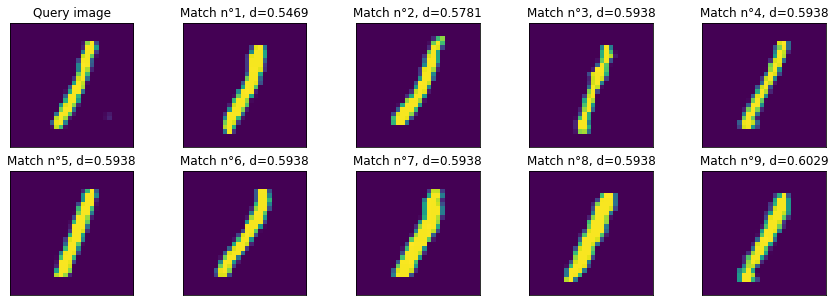

In [ ]:
fig, axs = plt.subplots(2,5, figsize=(15, 5))
axs = axs.ravel()
    
img = Image.fromarray(x_train[10007])
axs[0].imshow(img)
axs[0].title.set_text('Query image')
axs[0].set_xticks([]) 
axs[0].set_yticks([])
i=0
for k in l[0]:
  img = Image.fromarray(x_train[k])
  axs[i+1].imshow(img)
  axs[i+1].title.set_text('Match n°%d, d=%.4f'%(i+1, d[i]))
  axs[i+1].set_xticks([])
  axs[i+1].set_yticks([])
  i+=1